In [74]:
import pandas as pd
import spacy
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
import random
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
from spacy import displacy
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import contractions
pd.set_option("display.max_colwidth", 200)
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np

In [9]:
df=pd.read_csv("tweets.csv")

In [10]:
df.head()


,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


<Axes: xlabel='label'>

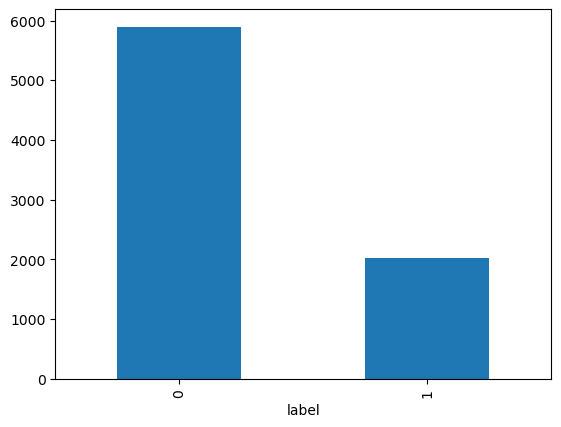

In [11]:
  df['label'].value_counts().plot(kind='bar')

In [12]:
  df['label'].value_counts(normalize=True)# 0 refers to positive sentiment, 1 is negative sentiment

label
0    0.744192
1    0.255808
Name: proportion, dtype: float64

In [13]:
df.isna().sum()

id       0
label    0
tweet    0
dtype: int64

In [14]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7920 entries, 0 to 7919
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7920 non-null   int64 
 1   label   7920 non-null   int64 
 2   tweet   7920 non-null   object
dtypes: int64(2), object(1)
memory usage: 185.8+ KB


# DataCleaning 

In [29]:
nltk_stopwords=set(stopwords.words("english"))
len(nltk_stopwords)

179

In [30]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
sklearn_stopwords = set(ENGLISH_STOP_WORDS)
print(len(sklearn_stopwords))

318


In [31]:
combined_stopwords = nltk_stopwords.union(sklearn_stopwords)
print(len(combined_stopwords))

378


In [40]:
lemmatizer = WordNetLemmatizer()

In [41]:
def tweet_cleaner(text):
    new_text = re.sub(r"'s\b", " is", text)
    new_text = re.sub("#", "", new_text)
    new_text = re.sub("@[A-Za-z0-9]+", "", new_text)
    new_text = re.sub(r'[^\w\s]', '', new_text)
    new_text = re.sub(r'\d+', '', new_text)
    new_text = re.sub(r"(http\S+|www\S+)", "", new_text)
    new_text = contractions.fix(new_text)    
    new_text = re.sub(r"[^a-zA-Z]", " ", new_text)    
    new_text = new_text.lower().strip()
    tokens = word_tokenize(new_text)
    cleaned_text = ''
    for token in tokens:
        if token not in combined_stopwords:
            cleaned_text = cleaned_text + lemmatizer.lemmatize(token) + ' '
    
    return cleaned_text

In [43]:
df["cleaned_tweets"] = list(df['tweet'].apply(tweet_cleaner))


In [46]:
df.head()

,id,label,tweet,cleaned_tweets
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone,fingerprint pregnancy test android apps beautiful cute health igers iphoneonly iphonesia iphone
1,2,0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/,finally transparant silicon case thanks uncle yay sony xperia sonyexperias
2,3,0,We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu,love talk makememories unplug relax iphone smartphone wifi connect
3,4,0,I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/,wired know george way iphone cute daventry home
4,5,1,What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!,amazing service apple talk question unless pay stupid support


['fingerprint', 'pregnancy', 'test', 'android', 'apps', 'beautiful', 'cute', 'health', 'igers', 'iphoneonly', 'iphonesia', 'iphone', 'finally', 'transparant', 'silicon', 'case', 'thanks', 'uncle', 'yay', 'sony', 'xperia', 'sonyexperias', 'love', 'talk', 'makememories', 'unplug', 'relax', 'iphone', 'smartphone', 'wifi', 'connect', 'wired', 'know', 'george', 'way', 'iphone', 'cute', 'daventry', 'home', 'amazing', 'service', 'apple', 'talk', 'question', 'unless', 'pay', 'stupid', 'support', 'iphone', 'software', 'update', 'fucked', 'phone', 'big', 'time', 'stupid', 'iphones', 'happy', 'instapic', 'instadaily', 'sony', 'xperia', 'xperiaz', 'new', 'type', 'c', 'charger', 'cable', 'uk', 'bay', 'amazon', 'etsy', 'new', 'year', 'rob', 'cross', 'toby', 'young', 'evemun', 'mcmafia', 'taylor', 'spectre', 'newyear', 'starting', 'recipe', 'technology', 'samsunggalaxys', 'iphonex', 'pictwittercompjiwqwtc', 'bout', 'shopping', 'listening', 'music', 'iphone', 'justme', 'music', 'likeforlike', 'followf

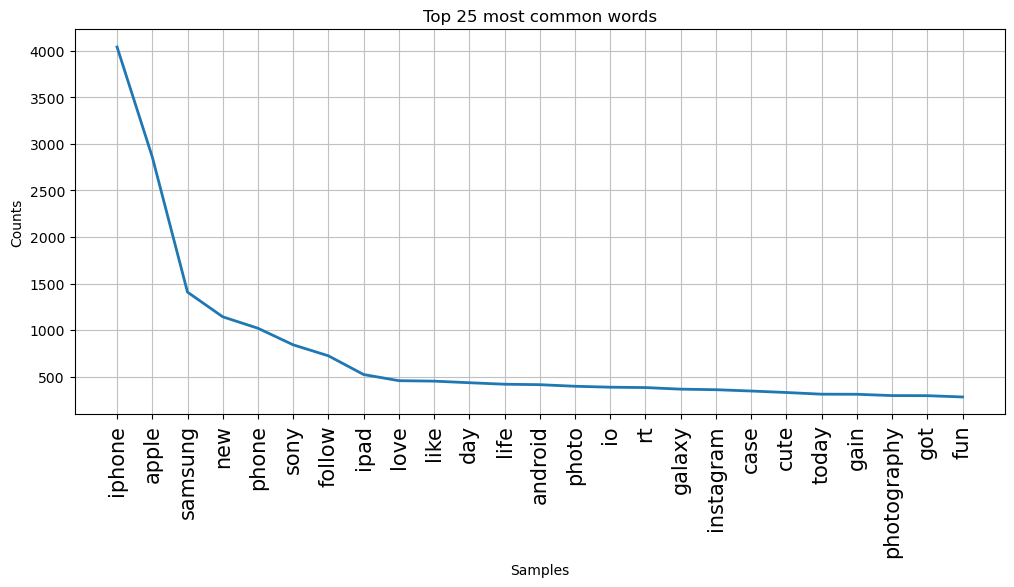

In [53]:
all_words = []
for t in df['cleaned_tweets']:
    tokens = word_tokenize(t)
    all_words.extend(tokens)

print(all_words[:100])

# Frequency Distribution
freq_dist = nltk.FreqDist(all_words)

plt.figure(figsize=(12,5))
plt.title('Top 25 most common words')
plt.xticks(fontsize=15)

freq_dist.plot(25, cumulative=False)

plt.show()

In [59]:
Domain_specific_words=['phone','twitter','rt','io','pictwittercompjiwqwtc','followforfollow','likeforlike']
combined_stopwords.update(set(Domain_specific_words))
len(combined_stopwords)

385

In [60]:
df["cleaned_tweets"] = list(df['tweet'].apply(tweet_cleaner))

['fingerprint', 'pregnancy', 'test', 'android', 'apps', 'beautiful', 'cute', 'health', 'igers', 'iphoneonly', 'iphonesia', 'iphone', 'finally', 'transparant', 'silicon', 'case', 'thanks', 'uncle', 'yay', 'sony', 'xperia', 'sonyexperias', 'love', 'talk', 'makememories', 'unplug', 'relax', 'iphone', 'smartphone', 'wifi', 'connect', 'wired', 'know', 'george', 'way', 'iphone', 'cute', 'daventry', 'home', 'amazing', 'service', 'apple', 'talk', 'question', 'unless', 'pay', 'stupid', 'support', 'iphone', 'software', 'update', 'fucked', 'big', 'time', 'stupid', 'iphones', 'happy', 'instapic', 'instadaily', 'sony', 'xperia', 'xperiaz', 'new', 'type', 'c', 'charger', 'cable', 'uk', 'bay', 'amazon', 'etsy', 'new', 'year', 'rob', 'cross', 'toby', 'young', 'evemun', 'mcmafia', 'taylor', 'spectre', 'newyear', 'starting', 'recipe', 'technology', 'samsunggalaxys', 'iphonex', 'bout', 'shopping', 'listening', 'music', 'iphone', 'justme', 'music', 'photo', 'fun', 'selfie', 'pool', 'water', 'sony']


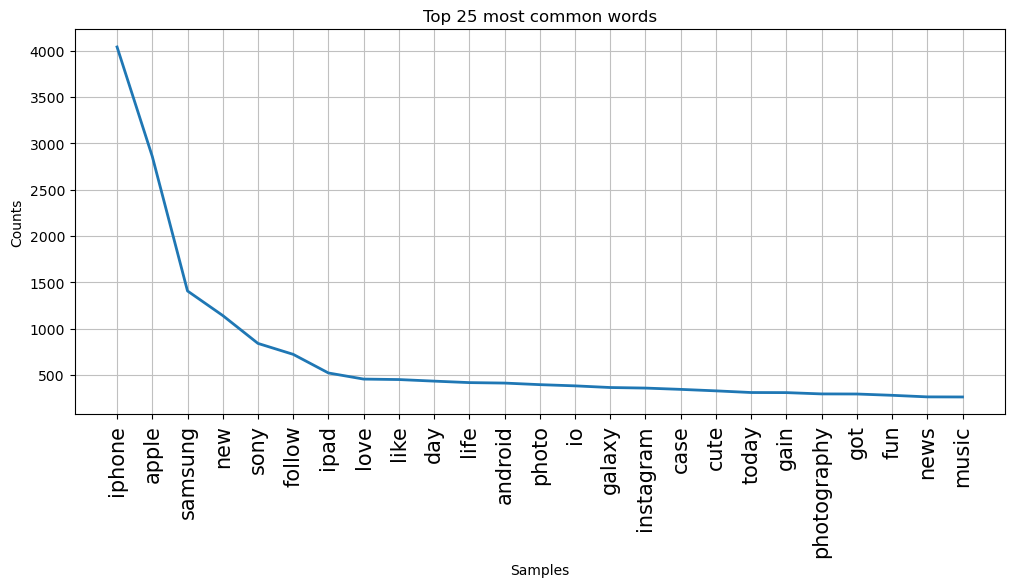

In [61]:
all_words = []
for t in df['cleaned_tweets']:
    tokens = word_tokenize(t)
    all_words.extend(tokens)

print(all_words[:100])

# Frequency Distribution
freq_dist = nltk.FreqDist(all_words)

plt.figure(figsize=(12,5))
plt.title('Top 25 most common words')
plt.xticks(fontsize=15)

freq_dist.plot(25, cumulative=False)

plt.show()

In [62]:
df.head(5)

,id,label,tweet,cleaned_tweets
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone,fingerprint pregnancy test android apps beautiful cute health igers iphoneonly iphonesia iphone
1,2,0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/,finally transparant silicon case thanks uncle yay sony xperia sonyexperias
2,3,0,We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu,love talk makememories unplug relax iphone smartphone wifi connect
3,4,0,I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/,wired know george way iphone cute daventry home
4,5,1,What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!,amazing service apple talk question unless pay stupid support


# Bag of Words Model (Feature Extraction)

In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer
X = df['cleaned_tweets']
y = df['label']

TFIDF = TfidfVectorizer(stop_words=combined_stopwords,min_df=5, max_features=1000)
TFIDF.fit_transform(X)
LR1=LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', C=0.4)
CV_pipe = Pipeline([('TFIDF', TFIDF) , ('LR', LR1)] )
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=43)
results = cross_validate(CV_pipe, X, y, cv=kfold, scoring='accuracy', return_train_score=True)
print(results['train_score'])
print(np.round((results['train_score'].mean())*100, 2), np.round((results['train_score'].std())*100, 2)) 

# print(results['test_score'])
print(np.round((results['test_score'].mean())*100, 2), np.round((results['test_score'].std())*100, 2)) 
len(TFIDF.vocabulary_) 

[0.86253157 0.86789773 0.86174242 0.86284722 0.86347854]
86.37 0.22
84.87 1.01


1000

In [80]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid to search through
param_grid = {
    'TFIDF__min_df': [3, 5, 7],
    'TFIDF__max_features': [1000, 2000, 3000],
    'LR__C': [0.1, 1.0, 10.0],
    'LR__penalty': ['l1', 'l2'],  # Regularization penalty
    'LR__solver': ['liblinear', 'saga'],  # Solver algorithm
    'LR__max_iter': [100, 300, 500],
}

# Perform GridSearchCV for hyperparameter tuning
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(CV_pipe, param_grid, cv=kfold, scoring='accuracy', return_train_score=True)
grid_search.fit(X, y)

# Print best hyperparameters and corresponding accuracy
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)


C:\Users\Vishal\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Vishal\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Vishal\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Vishal\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Vishal\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Vishal\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max

C:\Users\Vishal\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Vishal\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Vishal\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Vishal\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Vishal\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Vishal\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max

C:\Users\Vishal\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Vishal\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Vishal\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Vishal\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Vishal\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Vishal\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max

Best Hyperparameters: {'LR__C': 1.0, 'LR__max_iter': 100, 'LR__penalty': 'l2', 'LR__solver': 'liblinear', 'TFIDF__max_features': 3000, 'TFIDF__min_df': 3}
Best Accuracy: 0.8782828282828283


In [93]:
stoplist=list(combined_stopwords)
X = df['cleaned_tweets']
y = df['label']

# Create a pipeline with TF-IDF Vectorizer and Logistic Regression using best hyperparameters
pipeline = Pipeline([
    ('TFIDF', TfidfVectorizer(min_df=best_hyperparameters['TFIDF__min_df'],
                               max_features=best_hyperparameters['TFIDF__max_features'],stop_words=stoplist)),
    ('LR', LogisticRegression(class_weight='balanced',
                              solver=best_hyperparameters['LR__solver'],
                              penalty=best_hyperparameters['LR__penalty'],
                              C=best_hyperparameters['LR__C'],
                              max_iter=best_hyperparameters['LR__max_iter']))
])

# Fit the model using the best hyperparameters
pipeline.fit(X, y)


Pipeline(steps=[('TFIDF',
                 TfidfVectorizer(max_features=3000, min_df=3,
                                 stop_words=['although', 'with', 'everyone',
                                             'amount', 'ie', 'do', 'll',
                                             'couldnt', 'amongst', 'hundred',
                                             'something', 'a', 'about',
                                             'otherwise', 'whatever', 'she',
                                             'co', 'what', 'into', 'up',
                                             'seems', 'meanwhile', 'thereupon',
                                             'whenever', 'him', 'himself',
                                             "couldn't", 'eight', 'show',
                                             'mightn', ...])),
                ('LR',
                 LogisticRegression(class_weight='balanced',
                                    solver='liblinear'))])

In [94]:
import pickle
with open('sentiment_model.pkl', 'wb') as file:
    pickle.dump(pipeline, file)